## Epoch 2 -- Quicklook photometry, astrometry, and SNR

In [5]:
import numpy as np
import scipy.ndimage
import skimage.transform
import skimage.registration
import os
import pandas
import csv

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['image.cmap'] = 'inferno'
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['image.origin'] = 'lower'
plt.style.use('dark_background')

import astropy.units as u
import astropy.constants as c
import astropy.io.fits as fits
import astropy.table
import photutils

import scipy.signal
import scipy.interpolate

### File paths

In [6]:
#data_file_path = os.path.expanduser('~/Box Sync/Roman/Data_Challenges/cgi_data_challenge/data_official2019/')
#cal_file_path = os.path.expanduser('~/Box Sync/Roman/Data_Challenges/official/Official_part1/HLC CAL/')

#rdi_coadd_fname = os.path.join(data_file_path, 'HLC_scistar_RDI_rollcomb_seq.fits')
#star_cal_fname = os.path.join(data_file_path, "HLC_scistar_unocc_PSF_model.fits")
#psf_model_fname = os.path.join(data_file_path, 'hlc_centered_psf.fits')
#psf_peak_map_fname = os.path.join(cal_file_path, 'OS6_HLC_PSF_peak_map.fits')

In [7]:
analysis_results_dir = os.path.relpath("./results/")
cal_data_dir = os.path.relpath("../../Data/official2019/HLC/HLC CAL/")

rdi_coadd_fname = os.path.join(analysis_results_dir, "HLC_scistar_RDI_rollcomb_seq.fits")
psf_model_fname = os.path.join(analysis_results_dir, 'hlc_centered_psf.fits')

star_cal_fname = os.path.join(cal_data_dir, "HLC_scistar_unocc_PSF_model.fits")
psf_peak_map_fname = os.path.join(cal_data_dir, 'OS6_HLC_PSF_peak_map.fits')

In [8]:
#os.listdir(cal_data_dir)

### Misc. observation and data parameters

In [9]:
epoch_ind = 1

det_qe = 0.75 * u.electron / u.photon # effective QE of detector
pc_loss = 0.8 # photon counting coincidence losses
tot_inttime = 2 * 66000 * u.second
print(tot_inttime.to(u.hour))

36.666666666666664 h


In [10]:
hdr = fits.getheader(rdi_coadd_fname)
pix_scale = (hdr['PIX_AS'] * u.arcsecond).to(u.mas)
rdi_coadd_cube = fits.getdata(rdi_coadd_fname)
img_width = rdi_coadd_cube.shape[-1]
rdi_coadd_cube.shape

(4, 45, 45)

In [11]:
psf_peak_map = fits.getdata(psf_peak_map_fname)
psf_peak_map_hdr = fits.getheader(psf_peak_map_fname)
pixscale_ratio = hdr['PIX_LD'] / psf_peak_map_hdr['PIXSIZE']
print(pixscale_ratio)

4.2000023908478346


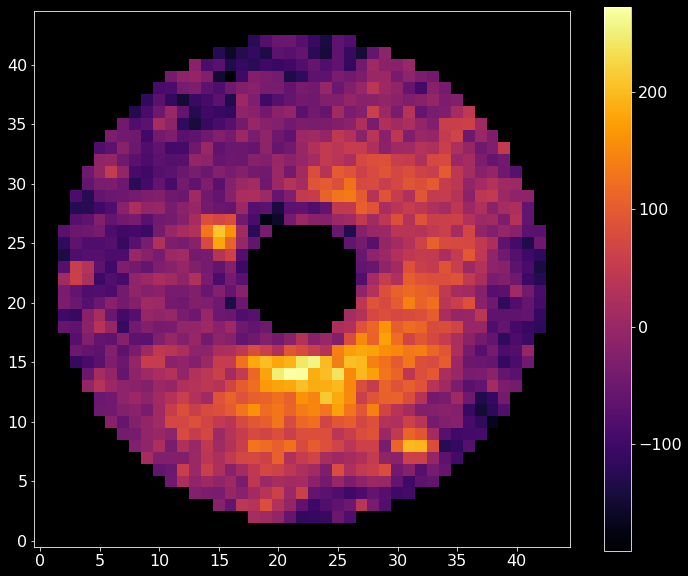

In [12]:
plt.figure(figsize=(12,10))
plt.imshow(rdi_coadd_cube[epoch_ind])
plt.colorbar()

In [13]:
peak_map_width = psf_peak_map.shape[0]

peak_map_xs = ((np.arange(peak_map_width) - peak_map_width // 2) 
               * pix_scale.value / pixscale_ratio)

peak_map_interp_func = scipy.interpolate.RegularGridInterpolator(
        (peak_map_xs, peak_map_xs), psf_peak_map)

data_xs = ((np.arange(img_width) - img_width // 2)
           * pix_scale.value)

data_YYs, data_XXs = np.meshgrid(data_xs, data_xs, indexing='ij')
data_interp_grid = (data_YYs.ravel(), data_XXs.ravel())

peak_map_interp_result = peak_map_interp_func(data_interp_grid)
peak_map_interp = peak_map_interp_result.reshape(data_XXs.shape)
peak_map_interp_norm = peak_map_interp / np.max(peak_map_interp)

print(peak_map_interp.shape)
print(psf_peak_map.max(), peak_map_interp.max())

(45, 45)
0.0006340347470915223 0.00063388371031199


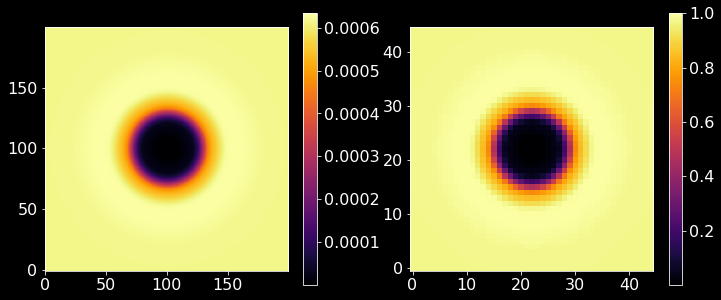

In [14]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(psf_peak_map)
plt.colorbar()
plt.subplot(122)
plt.imshow(peak_map_interp_norm)
plt.colorbar()

Peak col = 15, peak row = 26
Peak value = 209.1


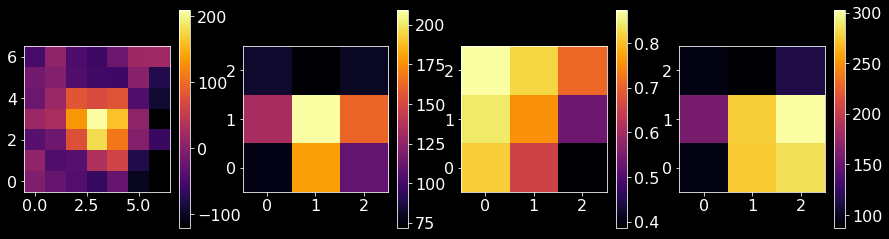

In [15]:
rdi_coadd_img = rdi_coadd_cube[epoch_ind]
img_width = rdi_coadd_img.shape[0]
phot_box_width = 3

XXs, YYs = np.meshgrid(np.arange(img_width), np.arange(img_width))

upperleft_quad_mask = ((XXs < img_width // 2) & (YYs > img_width // 2))

peak_row = np.nanargmax(np.ravel(rdi_coadd_img * upperleft_quad_mask)) // img_width
peak_col = np.nanargmax(np.ravel(rdi_coadd_img * upperleft_quad_mask)) % img_width
peak_val = rdi_coadd_img[peak_row, peak_col]

#phot_box_sum = np.sum(rdi_coadd_img[
#phot_box_sum = np.sum((rdi_coadd_img / peak_map_interp_norm)[
#                            peak_row - phot_box_width//2 : peak_row + phot_box_width // 2 + 1,
#                            peak_col - phot_box_width//2 : peak_col + phot_box_width // 2 + 1]) * u.electron

print("Peak col = {:d}, peak row = {:d}".format(peak_col, peak_row))
print("Peak value = {:.1f}".format(peak_val))
#print("Sum in {:d} x {:d} box = {:.2f}".format(phot_box_width, phot_box_width, phot_box_sum))

plt.figure(figsize=(15, 4))

plt.subplot(141)
plot_box_width = 7
plt.imshow((rdi_coadd_img)[
                    peak_row - plot_box_width//2 : peak_row + plot_box_width // 2 + 1,
                    peak_col - plot_box_width//2 : peak_col + plot_box_width // 2 + 1])
plt.colorbar()

plt.subplot(142)
plt.imshow(rdi_coadd_img[
                    peak_row - phot_box_width//2 : peak_row + phot_box_width // 2 + 1,
                    peak_col - phot_box_width//2 : peak_col + phot_box_width // 2 + 1])
plt.colorbar()

plt.subplot(143)
plt.imshow(peak_map_interp_norm[
                    peak_row - phot_box_width//2 : peak_row + phot_box_width // 2 + 1,
                    peak_col - phot_box_width//2 : peak_col + phot_box_width // 2 + 1])
plt.colorbar()

plt.subplot(144)
plt.imshow((rdi_coadd_img / peak_map_interp_norm)[
                    peak_row - phot_box_width//2 : peak_row + phot_box_width // 2 + 1,
                    peak_col - phot_box_width//2 : peak_col + phot_box_width // 2 + 1])
plt.colorbar()

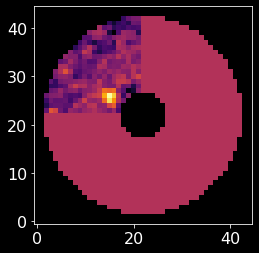

In [16]:
plt.imshow(upperleft_quad_mask * rdi_coadd_img)

B.g. estimate = -39.735 electron
B.g. std dev = 33.652 electron
B.g.-subtracted aperture sum = 1466.950 electron
Peak-to-B.g. SNR estimate = 7.4


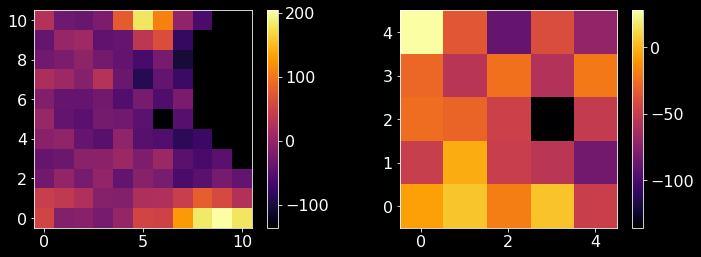

In [17]:
bg_samp_col = 15
bg_samp_row = 20
bg_box_width = 5
bg_est = np.median(rdi_coadd_img[
                 bg_samp_row - bg_box_width//2 : bg_samp_row + bg_box_width // 2 + 1,
                 bg_samp_col - bg_box_width//2 : bg_samp_col + bg_box_width // 2 + 1]) * u.electron

bg_std = np.std(rdi_coadd_img[
                 bg_samp_row - bg_box_width//2 : bg_samp_row + bg_box_width // 2 + 1,
                 bg_samp_col - bg_box_width//2 : bg_samp_col + bg_box_width // 2 + 1]) * u.electron

peak_to_bg_SNR = (peak_val * u.electron - bg_est) / bg_std

phot_box_sum_bgsub = np.sum(
#        ((rdi_coadd_img - bg_est.value) / peak_map_interp_norm)[
        ((rdi_coadd_img - bg_est.value) / 1)[
          peak_row - phot_box_width//2 : peak_row + phot_box_width // 2 + 1,
          peak_col - phot_box_width//2 : peak_col + phot_box_width // 2 + 1]) * u.electron

#phot_box_sum_bgsub = phot_box_sum - bg_est * (phot_box_width * phot_box_width)

print("B.g. estimate = {:.3f}".format(bg_est))
print("B.g. std dev = {:.3f}".format(bg_std))
print("B.g.-subtracted aperture sum = {:.3f}".format(phot_box_sum_bgsub))
print("Peak-to-B.g. SNR estimate = {:.1f}".format(peak_to_bg_SNR))

plt.figure(figsize=(12, 4))

plt.subplot(121)
plot_box_width = 10
plt.imshow(rdi_coadd_img[bg_samp_row - plot_box_width//2 : bg_samp_row + plot_box_width // 2 + 1,
                         bg_samp_col - plot_box_width//2 : bg_samp_col + plot_box_width // 2 + 1])
plt.colorbar()

plt.subplot(122)
plt.imshow(rdi_coadd_img[bg_samp_row - bg_box_width//2 : bg_samp_row + bg_box_width // 2 + 1,
                         bg_samp_col - bg_box_width//2 : bg_samp_col + bg_box_width // 2 + 1])
plt.colorbar()

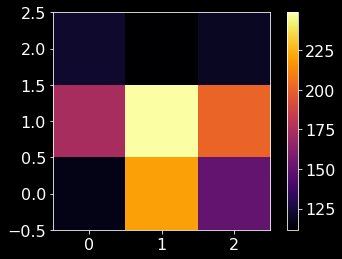

In [18]:
#plt.imshow(((rdi_coadd_img - bg_est.value) / peak_map_interp_norm)[
plt.imshow(((rdi_coadd_img - bg_est.value) / 1)[
        peak_row - phot_box_width//2 : peak_row + phot_box_width // 2 + 1,
        peak_col - phot_box_width//2 : peak_col + phot_box_width // 2 + 1])
plt.colorbar()

In [19]:
src_peak_map_col = (peak_map_width // 2 
                    + int(np.round((peak_col - img_width // 2)
                    * pixscale_ratio)))
src_peak_map_row = (peak_map_width // 2
                    + int(np.round((peak_row - img_width // 2)
                    * pixscale_ratio)))

print("Source position in peak map: {:}, {:}".format(src_peak_map_col, src_peak_map_row))

psf_atten = psf_peak_map[src_peak_map_row, src_peak_map_col] / np.max(psf_peak_map)
print("Relative PSF attenuation: {:.2f}".format(psf_atten))

Source position in peak map: 71, 117
Relative PSF attenuation: 0.75


25 25
Peak col = 25, peak row = 25
Star count rate in 3 x 3 box = 5955766.26 ph / s


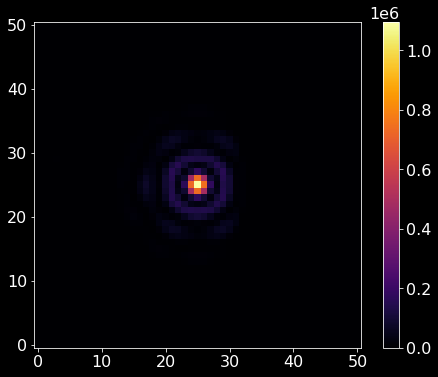

In [20]:
star_cal_img = fits.getdata(star_cal_fname)
star_cal_img_width = star_cal_img.shape[0]

star_peak_row = np.nanargmax(np.ravel(star_cal_img)) // star_cal_img_width
star_peak_col = np.nanargmax(np.ravel(star_cal_img)) % star_cal_img_width
print(star_peak_col, star_peak_row)

star_phot_box_sum = (np.sum(star_cal_img[star_peak_row - phot_box_width//2 : star_peak_row + phot_box_width // 2 + 1,
                                         star_peak_col - phot_box_width//2 : star_peak_col + phot_box_width // 2 + 1])
                     * u.photon / u.second)

print("Peak col = {:d}, peak row = {:d}".format(star_peak_col, star_peak_row))
print("Star count rate in {:d} x {:d} box = {:.2f}".format(phot_box_width, phot_box_width, star_phot_box_sum))

plt.figure(figsize=(8,6))
plt.imshow(star_cal_img)
plt.colorbar()

In [21]:
planet_phot_box_sum = (phot_box_sum_bgsub / (det_qe * pc_loss) / psf_atten) / tot_inttime
print("Planet PSF photon count rate in {:d} x {:d} box = {:.2E}".format(
      phot_box_width, phot_box_width, planet_phot_box_sum))

planet_flux_ratio = planet_phot_box_sum / star_phot_box_sum
print("Measured planet flux ratio = {:.3E}".format(planet_flux_ratio))

Planet PSF photon count rate in 3 x 3 box = 2.48E-02 ph / s
Measured planet flux ratio = 4.171E-09


## Photutils centroid and photometry 

In [22]:
cut_width = 5
#src_cutout = ((rdi_coadd_img - bg_est.value) / peak_map_interp_norm)[
src_cutout = (rdi_coadd_img - bg_est.value)[
        peak_row - cut_width//2 : peak_row + cut_width // 2 + 1,
        peak_col - cut_width//2 : peak_col + cut_width // 2 + 1]


src_cutout[src_cutout < 0] = 0

bg_box = rdi_coadd_img[bg_samp_row - bg_box_width//2 : bg_samp_row + bg_box_width // 2 + 1,
                       bg_samp_col - bg_box_width//2 : bg_samp_col + bg_box_width // 2 + 1]

bg_std = np.std(bg_box)
print(bg_std)

33.65166378044706


In [23]:
np.nanstd(rdi_coadd_img)

73.85957527027288

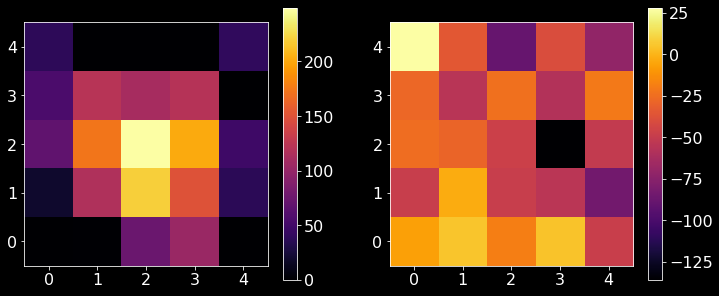

In [24]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(src_cutout)
plt.colorbar()
plt.subplot(122)
plt.imshow(bg_box)
plt.colorbar()

In [27]:
#result = photutils.centroids.fit_2dgaussian(data = src_cutout,

result = photutils.centroids.centroid_2dg(data = src_cutout,
                                          error = np.ones_like(src_cutout) * bg_std)

In [28]:
result

array([2.05067317, 1.74633821])

In [29]:
psf_model = fits.getdata(psf_model_fname)
psf_model_shift = scipy.ndimage.shift(psf_model, [0.5, 0.5])
psf_model_crop = 11
psf_model_crop = psf_model_shift[psf_model.shape[0] // 2 - psf_model_crop//2:psf_model.shape[0] // 2 + psf_model_crop//2 + 1,
                                 psf_model.shape[0] // 2 - psf_model_crop//2:psf_model.shape[0] // 2 + psf_model_crop//2 + 1]

In [30]:
psf_model_crop.shape

(11, 11)

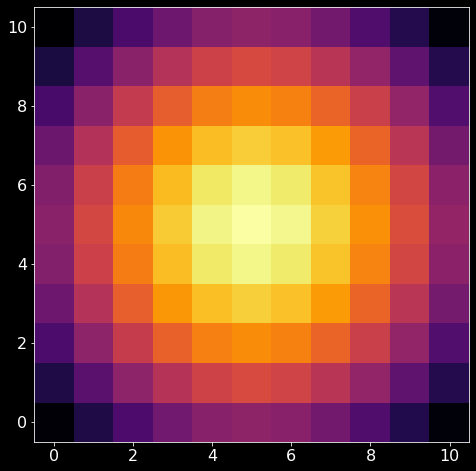

In [31]:
plt.figure(figsize=(8,8))
plt.imshow(psf_model_crop[:,:])

In [32]:
hdr = fits.getheader(rdi_coadd_fname)
print(hdr['PIX_AS'])
print(hdr['PIX_LD'])

scale_fac = hdr['PIX_LD'] / 0.1
src_cutout_rescaled = skimage.transform.rescale(src_cutout, scale = scale_fac)
print(src_cutout_rescaled.shape)

0.0210804
0.4200002390847835
(21, 21)


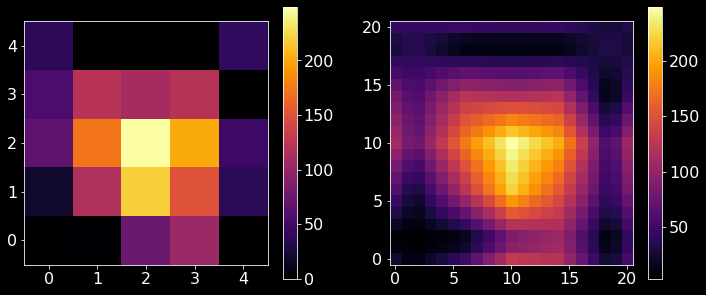

In [33]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(src_cutout)
plt.colorbar()
plt.subplot(122)
plt.imshow(src_cutout_rescaled)
plt.colorbar()

In [34]:
#src_crop = src_cutout_rescaled.shape[0] - psf_model_crop.shape[0]
src_cutout_rescaled_cropped = src_cutout_rescaled[
        src_cutout_rescaled.shape[0] // 2 - psf_model_crop.shape[0] // 2:src_cutout_rescaled.shape[0] // 2 + psf_model_crop.shape[0] // 2 + 1,
        src_cutout_rescaled.shape[0] // 2 - psf_model_crop.shape[0] // 2:src_cutout_rescaled.shape[0] // 2 + psf_model_crop.shape[0] // 2 + 1]

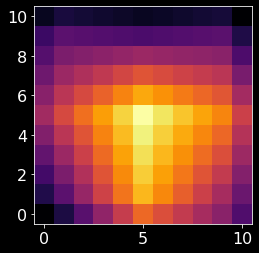

In [35]:
plt.figure()
plt.imshow(src_cutout_rescaled_cropped)

In [36]:
src_cutout_rescaled_cropped.shape

(11, 11)

In [37]:
cross_corr_result = skimage.registration.phase_cross_correlation(reference_image = psf_model_crop,
                                                                 moving_image = src_cutout_rescaled_cropped,
                                                                 upsample_factor = 10)

In [38]:
#help(skimage.registration.phase_cross_correlation)

In [39]:
cross_corr_result

(array([ 0.9, -0.4]), 0.10503411834761929, 4.489270967797688e-18)

In [40]:
src_y = peak_row - cross_corr_result[0][0] / scale_fac
src_x = peak_col - cross_corr_result[0][1] / scale_fac

In [41]:
peak_row, peak_col

(26, 15)

In [42]:
src_y, src_x

(25.785714407696247, 15.09523804102389)

In [43]:
pix_scale = (hdr['PIX_AS'] * u.arcsecond).to(u.mas)
src_y_offset = (src_y - img_width // 2) * pix_scale
src_x_offset = (src_x - img_width // 2) * pix_scale

In [44]:
src_y_offset.to(u.mas), src_x_offset.to(u.mas)

(<Quantity 79.804374 mas>, <Quantity -145.555144 mas>)

In [45]:
sigma = (1 / hdr['PIX_LD']) / peak_to_bg_SNR * pix_scale

In [46]:
sigma

<Quantity 6.78735708 mas>

## Fit source with OS9 HLC PSF model

### first few cells copied from exoscene demo notebook: https://github.com/nasa/exoscene/blob/master/exoscene/docs/notebooks/Roman-CGI_scene_demo.ipynb

In [62]:
import exoscene.image
import pkg_resources

In [63]:
hlc_psf_path =  pkg_resources.resource_filename('exoscene', 'data/cgi_hlc_psf')
os.listdir(hlc_psf_path)

['os9_psfs_r_offset.fits', 'os9_psfs_angle_offset.fits', 'os9_psfs.fits']

In [64]:
psf_cube_fname = os.path.join(hlc_psf_path, 'os9_psfs.fits')
psf_r_fname = os.path.join(hlc_psf_path, 'os9_psfs_r_offset.fits')
psf_angle_fname = os.path.join(hlc_psf_path, 'os9_psfs_angle_offset.fits')

psf_cube = fits.getdata(psf_cube_fname)
psf_hdr = fits.getheader(psf_cube_fname)
print("Shape of PSF model: {:}".format(psf_cube.shape))

Shape of PSF model: (10, 19, 200, 200)


In [65]:
data_pixscale_as = (21.08 * u.milliarcsecond).to(u.arcsec) # Pixel scale of CGI science camera
hires_pixscale_as = psf_hdr['PIX_AS'] * u.arcsec
hires_pixscale_LoD = psf_hdr['PIXSCALE']

data_scale_fac = hires_pixscale_as.value / data_pixscale_as.value
data_pixscale_LoD = hires_pixscale_LoD / data_scale_fac
print("CCD pixel to model pixel scale factor = {:.3f}".format(data_scale_fac))

r_offsets_LoD = fits.getdata(psf_r_fname)[0, :]
r_offsets_as = r_offsets_LoD * hires_pixscale_as / hires_pixscale_LoD
angles = fits.getdata(psf_angle_fname)[:, 0]

Np_psf_hires = psf_cube.shape[-1]

CCD pixel to model pixel scale factor = 0.238


In [66]:
offset_psfs = scipy.ndimage.interpolation.shift(psf_cube, (0, 0, -0.5, -0.5),
                                                order = 1, prefilter=False,
                                                mode = 'constant', cval=0)

Np = offset_psfs.shape[-1]
cx = Np // 2 - 0.5 # New array center in zero-based indices
print("Dimensions of PSF model cube: {:}".format(offset_psfs.shape))
print("New array center along both axes: {:.1f}".format(cx))

Dimensions of PSF model cube: (10, 19, 200, 200)
New array center along both axes: 99.5


### Get hi-res model PSF at estimated centroid

In [67]:
src_x_offset.to(u.arcsec), src_y_offset.to(u.arcsec)

(<Quantity -0.14555514 arcsec>, <Quantity 0.07980437 arcsec>)

In [68]:
npad = 8 # pad before and after array edge before binning
max_detect_width = 1.1 * u.arcsec
test_hires_psf = exoscene.image.get_hires_psf_at_xy_os9(
        offset_psfs,
        r_offsets_as.value, angles,
        hires_pixscale_as.value,
        delx_as = src_x_offset.to(u.arcsec).value,
        dely_as = src_y_offset.to(u.arcsec).value,
        cx = cx)

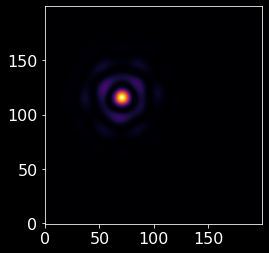

In [70]:
plt.imshow(test_hires_psf)